Voc Up = 0.9855
jSC Up = -0.19
jmax Up = -0.13899999999999998
Vmax Up = 0.5985
Voc Down = 0.875
jSC Down = -0.14200000000000002
jmax Down = -0.11
Vmax Down = 0.488
Área de Histeresis: 0.04321253563096612 mA·cm²
Porcentaje de Histeresis: 32.81%


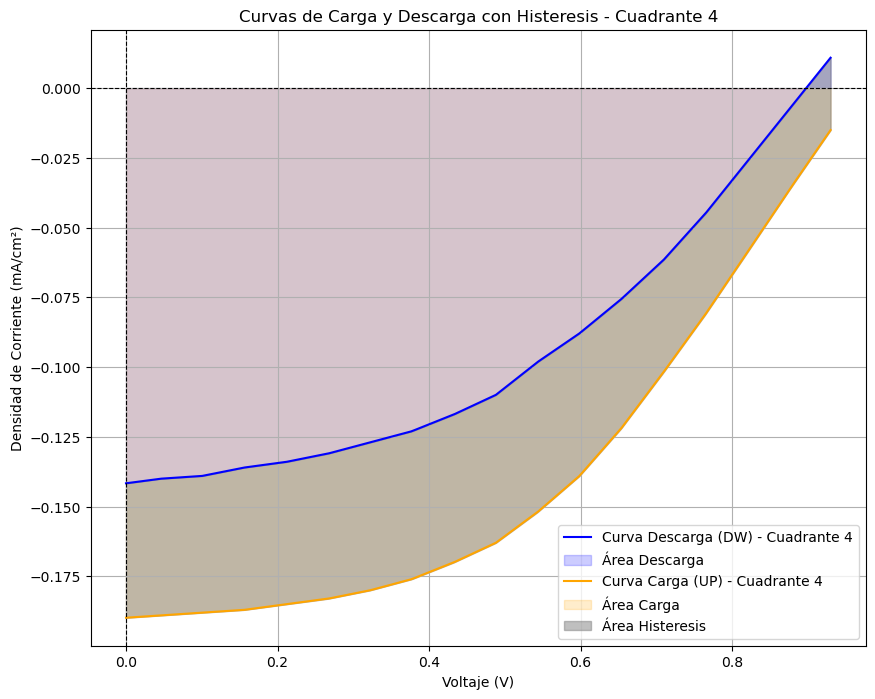

In [3]:
#Hallar Parámetros fotovoltaicos (run only once)
#Import data from pkl (provided by _macro-datos) 

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pandas as pd

pklName = 'celda1_ciclo 73_05-11-2024.pkl'

df1 = pd.read_pickle(pklName)

#Set area according to file name (ex: celda1 -> 1 cm^2 ; celda2 -> 20.25 cm^2)
if pklName[5] == "1":
    Ama = 1.0
elif pklName[5] == "2":     
    Ama = 20.25



pd.options.mode.copy_on_write = True
df = df1.rename(columns={"Iup": "iUp", "Idw": "iDw"})               #Adapt to local names   

def zeroMask(df1, var):
   
    return (df1[var] - 0.).abs().idxmin()                            #index of the 'var' value closest to zero 

def tangetMask(df1, x_var, y_var):
    x = df1[x_var] ; y = df1[y_var]
    return (np.abs(np.gradient(x, y/Ama) - 1.)).argmin()             #index where derivative of y_var w/r/ to x_var is closest to 1         

def productMask(df2, x_var, y_var):
    df3 = df2[df2[y_var] < 0]
    df3['product'] = (df3[x_var] * df3[y_var]).abs()            # add a new column to the local df
    return df3['product'].idxmax()

df[['iUp', 'iDw']] = df[['iUp', 'iDw']]*1000                    # [A] to [mA]    

    
jSC_up = df['iUp'][zeroMask(df, 'Vup')]  / Ama                  # [mA/cm²]  
jSC_dw = df['iDw'][zeroMask(df, 'Vdw')]  / Ama

Voc_up = df['Vup'][zeroMask(df, 'iUp')]                         # [V]
Voc_dw = df['Vdw'][zeroMask(df, 'iDw')] 


Vmax_up = df['Vup'][productMask(df, 'Vup', 'iUp')]                
jMax_up = df['iUp'][productMask(df, 'Vup', 'iUp')] / Ama          
    
Vmax_dw = df['Vdw'][productMask(df, 'Vdw', 'iDw')]                
jMax_dw = df['iDw'][productMask(df, 'Vdw', 'iDw')] / Ama          

Voc = [Voc_up, Voc_dw] ; jSC = [jSC_up, jSC_dw]
Vmax = [Vmax_up, Vmax_dw] ; jMax = [jMax_up, jMax_dw]

dir = ['Up', 'Down'] 
for i in range(2):
    print("Voc {} = {}".format(dir[i],Voc[i]))
    print("jSC {} = {}".format(dir[i],jSC[i]))
    print("jmax {} = {}".format(dir[i],jMax[i]))
    print("Vmax {} = {}".format(dir[i], Vmax[i]))


############ Calculo Histeresis
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Filtrar los datos para el cuadrante 4 (J < 0)
df_dw_quad4 = df[df['iDw'] < 0]  # Descarga
df_up_quad4 = df[df['iUp'] < 0]  # Carga

# Intervalos para las áreas
x_dw_quad4 = df_dw_quad4['Vdw']  # Voltaje (descarga)
y_dw_quad4 = df_dw_quad4['iDw'] / Ama  # Densidad de corriente (descarga)

x_up_quad4 = df_up_quad4['Vup']  # Voltaje (carga)
y_up_quad4 = df_up_quad4['iUp'] / Ama  # Densidad de corriente (carga)

# Crear interpolación de las curvas para obtener un rango común de voltaje
x_common = np.linspace(0, max(x_up_quad4.max(), x_dw_quad4.max()), 500)

# Interpolación de las curvas de carga y descarga
interp_dw = interp1d(x_dw_quad4, y_dw_quad4, kind='linear', fill_value="extrapolate")
interp_up = interp1d(x_up_quad4, y_up_quad4, kind='linear', fill_value="extrapolate")

# Obtener los valores interpolados
y_common_dw = interp_dw(x_common)
y_common_up = interp_up(x_common)

# Calcular el área encerrada entre las curvas usando el método del trapecio
area_histeresis = np.trapz(np.abs(y_common_up - y_common_dw), x_common)

# Calcular el área total bajo las curvas (usamos la curva de carga o descarga)
area_total_dw = np.trapz(np.abs(y_common_dw), x_common)
area_total_up = np.trapz(np.abs(y_common_up), x_common)

# El área total es la mayor de las dos áreas (de carga o descarga)
area_total = max(area_total_dw, area_total_up)

# Calcular el porcentaje de histeresis
porcentaje_histeresis = (area_histeresis / area_total) * 100

# Mostrar el área de histeresis y el porcentaje
print(f"Área de Histeresis: {area_histeresis} mA·cm²")
print(f"Porcentaje de Histeresis: {porcentaje_histeresis:.2f}%")

# Graficar las curvas con el área encerrada
plt.figure(figsize=(10, 8))

# Graficar la curva de descarga (DW) en el cuadrante 4
plt.plot(x_common, y_common_dw, label='Curva Descarga (DW) - Cuadrante 4', color='blue')
plt.fill_between(x_common, y_common_dw, 0, color='blue', alpha=0.2, label='Área Descarga')

# Graficar la curva de carga (UP) en el cuadrante 4
plt.plot(x_common, y_common_up, label='Curva Carga (UP) - Cuadrante 4', color='orange')
plt.fill_between(x_common, y_common_up, 0, color='orange', alpha=0.2, label='Área Carga')

# Resaltar el área encerrada entre las dos curvas
plt.fill_between(x_common, y_common_up, y_common_dw, color='gray', alpha=0.5, label='Área Histeresis')

# Personalización de la gráfica
plt.title('Curvas de Carga y Descarga con Histeresis - Cuadrante 4')
plt.xlabel('Voltaje (V)')
plt.ylabel('Densidad de Corriente (mA/cm²)')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Línea horizontal en J = 0
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')  # Línea vertical en V = 0
plt.legend()
plt.grid(True)

# Guardar la imagen
plt.savefig("curva_carga_descarga_histeresis_area.png", dpi=300)
plt.show()


/tmp/ipykernel_238855/2142108888.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_dw_quad4 = y_dw_quad4[np.argsort(df_dw_quad4['Vdw'])]
/tmp/ipykernel_238855/2142108888.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_up_quad4 = y_up_quad4[np.argsort(df_up_quad4['Vup'])]
/tmp/ipykernel_238855/2142108888.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  delta_y = np.abs(y_up_quad4[i] - y_dw_quad4[i])


Área de Histeresis: 0.040403609088333334 mA·cm²
Porcentaje de Histeresis: 30.24%


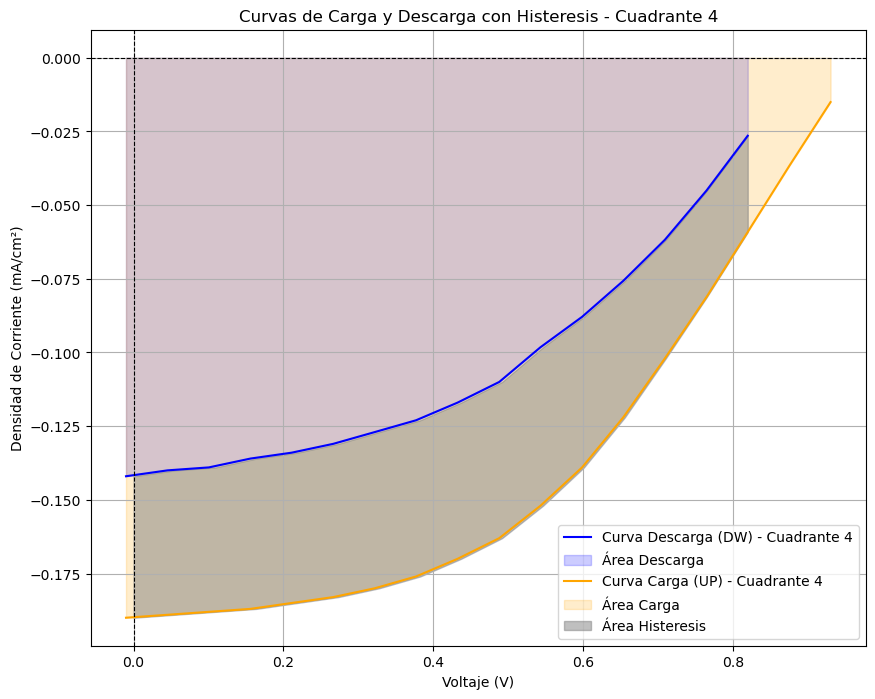

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Filtrar los datos para el cuadrante 4 (J < 0)
df_dw_quad4 = df[df['iDw'] < 0]  # Descarga
df_up_quad4 = df[df['iUp'] < 0]  # Carga

# Puntos de voltaje y corriente para descarga (DW) y carga (UP)
x_dw_quad4 = df_dw_quad4['Vdw']  # Voltaje (descarga)
y_dw_quad4 = df_dw_quad4['iDw'] / Ama  # Densidad de corriente (descarga)

x_up_quad4 = df_up_quad4['Vup']  # Voltaje (carga)
y_up_quad4 = df_up_quad4['iUp'] / Ama  # Densidad de corriente (carga)

# Asegurarse de que los puntos de voltaje estén en orden creciente
x_dw_quad4 = np.sort(x_dw_quad4)
y_dw_quad4 = y_dw_quad4[np.argsort(df_dw_quad4['Vdw'])]

x_up_quad4 = np.sort(x_up_quad4)
y_up_quad4 = y_up_quad4[np.argsort(df_up_quad4['Vup'])]

# Asegurarse de que las curvas de carga y descarga tengan el mismo número de puntos
min_length = min(len(x_dw_quad4), len(x_up_quad4))
x_common = np.linspace(0, min(x_dw_quad4[-1], x_up_quad4[-1]), min_length)

# Calcular la diferencia entre las curvas de carga y descarga en cada punto
area_histeresis = 0
for i in range(min_length - 1):
    # Calcular el área entre los puntos
    delta_x = x_common[i+1] - x_common[i]
    delta_y = np.abs(y_up_quad4[i] - y_dw_quad4[i])
    area_histeresis += delta_x * delta_y

# Calcular el área total bajo las curvas
area_total_dw = np.trapz(np.abs(y_dw_quad4), x_dw_quad4)
area_total_up = np.trapz(np.abs(y_up_quad4), x_up_quad4)

# El área total es la mayor de las dos áreas (de carga o descarga)
area_total = max(area_total_dw, area_total_up)

# Calcular el porcentaje de histeresis
porcentaje_histeresis = (area_histeresis / area_total) * 100

# Mostrar el área de histeresis y el porcentaje
print(f"Área de Histeresis: {area_histeresis} mA·cm²")
print(f"Porcentaje de Histeresis: {porcentaje_histeresis:.2f}%")

# Graficar las curvas con el área encerrada
plt.figure(figsize=(10, 8))

# Graficar la curva de descarga (DW) en el cuadrante 4
plt.plot(x_dw_quad4, y_dw_quad4, label='Curva Descarga (DW) - Cuadrante 4', color='blue')
plt.fill_between(x_dw_quad4, y_dw_quad4, 0, color='blue', alpha=0.2, label='Área Descarga')

# Graficar la curva de carga (UP) en el cuadrante 4
plt.plot(x_up_quad4, y_up_quad4, label='Curva Carga (UP) - Cuadrante 4', color='orange')
plt.fill_between(x_up_quad4, y_up_quad4, 0, color='orange', alpha=0.2, label='Área Carga')

# Resaltar el área encerrada entre las dos curvas
plt.fill_between(x_common, y_up_quad4[:min_length], y_dw_quad4[:min_length], color='gray', alpha=0.5, label='Área Histeresis')

# Personalización de la gráfica
plt.title('Curvas de Carga y Descarga con Histeresis - Cuadrante 4')
plt.xlabel('Voltaje (V)')
plt.ylabel('Densidad de Corriente (mA/cm²)')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Línea horizontal en J = 0
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')  # Línea vertical en V = 0
plt.legend()
plt.grid(True)

# Guardar la imagen
plt.savefig("curva_carga_descarga_histeresis_area_punto_a_punto.png", dpi=300)
plt.show()
